In [36]:
%matplotlib inline

from IPython.core.magic import register_line_magic
                                
import matplotlib.pyplot as plt

from annoy import AnnoyIndex
import torch.nn as nn

# from fastai.vision import ConvLearner 
from fastai import vision
import fastai
from torchsummary import summary

from PIL import Image
import requests

from tqdm import tqdm


from fastai import torch_core

import torchvision.models as tvm
from torch.utils.data import Dataset, DataLoader
import torch

import cv2
import glob
import numpy as np
import os

import torchvision
import torchvision.transforms as transforms

# Introduction
installation ![][img-overview]

[img-overview]: https://i.imgur.com/xLtNhLp.png

# Util functions

In [2]:
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Data Preparation
TODO: where should one download data or training images?

In [3]:
DATA_PATH = '../data/moma-artworks-1000/'
TRANSFORMATION_PARAMS = dict(
    size=224, 
    padding_mode="zeros"
)

In [5]:
# This class is responsible for transforming images (aka. preprocessing)
# before being feed to a neural network
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        # Look for jpegs in the directory
        self.image_paths = sorted(glob.glob(root_dir + '*.jpeg'))
        assert self.image_paths != 0, "No images found in {}".format(root_dir)

        self.image_names = [os.path.basename(path) for path in self.image_paths]
        _, self.tfms = vision.get_transforms()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index, with_transformation=True):
        image_path = self.image_paths[index]
        
        # Returns image in RGB format; each pixel ranges between 0.0 and 1.0
        image = vision.open_image(image_path)

        if not with_transformation:
            return image.px

        # Apply transforms to the image        
        return self.transform(self.tfms, image).px
    
    def transform(self, tfms, img):
        return img.apply_tfms(tfms, **TRANSFORMATION_PARAMS)
    
    def get(self, index, **kwargs):
        return self.__getitem__(index, **kwargs)

In [6]:
dataset = ImageDataset(DATA_PATH)

In [7]:
print('We have %d images' % len(dataset.image_paths))

We have 5934 images


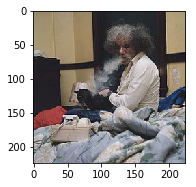

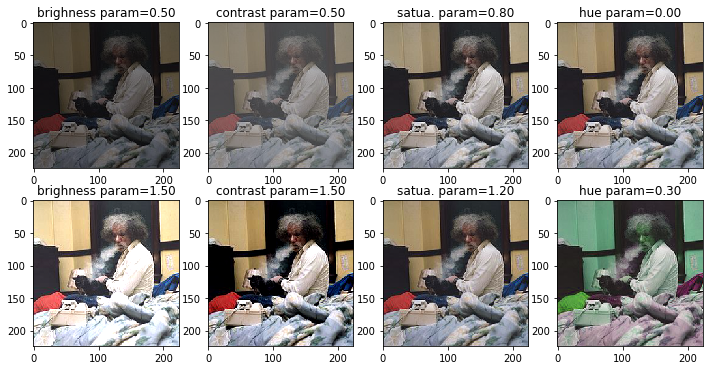

In [168]:
plt.subplot(1, 2, 1)
img_torch = dataset.get(32)
img_tp = img_torch.permute(1, 2, 0)

img = img_tp.numpy()
img_p = transforms.ToPILImage()(img_torch)

plt.imshow(img)
plt.show()
transform_list = [
    ('brighness', transforms.functional.adjust_brightness, 0.5, 1.5),
    ('contrast', transforms.functional.adjust_contrast, 0.5, 1.5),
    ('satua.', transforms.functional.adjust_saturation, 0.8, 1.2),
    ('hue', transforms.functional.adjust_hue, 0, 0.3),
]

total_transform = len(transform_list)
plt.figure(figsize=(3*total_transform, 6))
count = 1
for s, t, l, h in transform_list:
    plt.subplot(2, total_transform, count)
    ii = t(img_p, l)
    plt.imshow(ii)
    plt.title('%s param=%.2f' % (s, l))
    

    plt.subplot(2, total_transform, count+total_transform)
    ii = t(img_p, h)
    plt.imshow(ii)
    plt.title('%s param=%.2f' % (s, h))
    count += 1
# img2 = img2, 1.5)
# plt.subplot(1, 2, 2)
# plt.imshow(img2)

In [100]:
from PIL import Image

In [176]:
base_transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])
noisy_transform = transforms.RandomChoice([
    transforms.ColorJitter(brightness=0.5),
    transforms.ColorJitter(contrast=0.5),
    transforms.ColorJitter(saturation=0.2),
])

class NoisyImageDataset(ImageDataset):
    def __init__(self, root_dir, transform=None, noisy_transform=None):
        # Look for jpegs in the directory
        self.image_paths = sorted(glob.glob(root_dir + '*.jpeg'))
        assert self.image_paths != 0, "No images found in {}".format(root_dir)

        self.image_names = [os.path.basename(path) for path in self.image_paths]
        self.transform = transform
        
        self.noisy_transofrm =  transforms.Compose([noisy_transform, self.transform])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index, with_transformation=True):
        image_path = self.image_paths[index]
        
        # Returns image in RGB format; each pixel ranges between 0.0 and 1.0
        image = Image.open(image_path).convert('RGB')
        x = self.transform(image)
        x_mod = self.noisy_transofrm(image)
        
        return x, x_mod 

    def get(self, index, **kwargs):
        return self.__getitem__(index, **kwargs)
    
noisy_dataset = NoisyImageDataset(DATA_PATH, transform=base_transform, noisy_transform=noisy_transform)

In [177]:
trainloader = torch.utils.data.DataLoader(noisy_dataset, batch_size=32, shuffle=True, num_workers=2)

In [215]:
test_noisy_dataset = NoisyImageDataset('../data/moma-artworks-1000/', transform=base_transform, noisy_transform=noisy_transform)
testloader = torch.utils.data.DataLoader(test_noisy_dataset, batch_size=4, shuffle=False, num_workers=2)

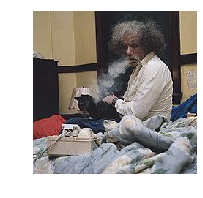

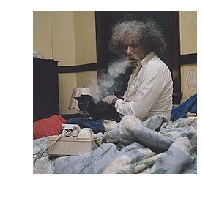

In [178]:
bb = noisy_dataset[32]
vision.image.show_image(bb[0])
vision.image.show_image(bb[1])

# AutoEncoder
image -> encoder -> z -> decoder -> image

In [110]:
import torch.nn.functional as F

import torch.nn as nn
from functools import reduce
import torch.optim as optim

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)

In [111]:
class VanillaVAE(nn.Module):
    def __init__(self, verbose=False):
        super(VanillaVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(True),
            nn.Linear(120, 84),
            nn.ReLU(True),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(84, 120),
            nn.ReLU(True),
            nn.Linear(120, 16*5*5),
            nn.ReLU(True),
            Reshape([16, 5, 5]),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 6, 5),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(6, 3, 5),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def parameters(self):
        return list(self.encoder.parameters()) + list(self.decoder.parameters())

# VAE

In [112]:
class VAE(nn.Module):
    def __init__(self, latent_dims=2, verbose=False):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            Flatten(),
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(True),
            nn.Linear(120, 2*latent_dims),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 120),
            nn.ReLU(True),
            nn.Linear(120, 16*4*4),
            nn.ReLU(True),
            Reshape([16, 4, 4]),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 6, 5),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(6, 1, 5),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        z_mu, z_logvar = torch.chunk(h, 2, dim=1)
        z_mu = z_mu.view(z_mu.size(0), -1)
        z_logvar = z_logvar.view(z_logvar.size(0), -1)
        
        z_logvar = nn.Softplus()(z_logvar)
        
        z = self.sampling(z_mu, z_logvar)

        x_hat = self.decoder(z)
        return x_hat, z, z_mu, z_logvar
    
    def sampling(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def parameters(self):
        return list(self.encoder.parameters()) + list(self.decoder.parameters())

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return (BCE + KLD) / (mu.shape[0]*mu.shape[1])

# Denoise VAE

In [188]:
class DVAE(nn.Module):
    def __init__(self, latent_dims=2, verbose=False):
        super(DVAE, self).__init__()
        
        self.latent_dims = latent_dims
        self.dm = nn.Linear(128, latent_dims)
        self.dv = nn.Linear(128, latent_dims)

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 10, 5), nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(10, 5, 5), nn.ReLU(True),
            nn.MaxPool2d(4, 4),
            nn.Conv2d(5, 20, 5), nn.ReLU(True),
            nn.MaxPool2d(4, 4),
            Flatten(),
            nn.Linear(500, 256), nn.ReLU(True),
            nn.Linear(256, 128), nn.ReLU(True),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 128), nn.ReLU(True),
            nn.Linear(128, 256), nn.ReLU(True),
            nn.Linear(256, 500), nn.ReLU(True),
            Reshape([20, 5, 5]),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(20, 5, 4), nn.ReLU(True),
            nn.Upsample(scale_factor=4),
            nn.ConvTranspose2d(5, 5, 5), nn.ReLU(True),
            nn.Upsample(scale_factor=4),
            nn.ConvTranspose2d(5, 3, 1), nn.Sigmoid()
        )


    def forward(self, x):
        h = self.encoder(x)
        z_mu = self.dm(h)
        
        z_logvar = self.dv(h)
        
        z_logvar = nn.Softplus()(z_logvar)
        
        z = self.sampling(z_mu, z_logvar)

        x_hat = self.decoder(z)
        return x_hat, z, z_mu, z_logvar
    
    def sampling(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def parameters(self):
        return list(self.encoder.parameters()) + list(self.decoder.parameters()) + \
            list(self.dm.parameters()) + list(self.dv.parameters())



In [190]:
running_loss = []

dvae = DVAE(latent_dims=100)

optimizer = optim.Adam(dvae.parameters(), lr=0.001)

for epoch in range(5):
    for i, data in enumerate(trainloader, 0):
        x, x_mod = data

        optimizer.zero_grad()

        x_hat, z, z_mu, z_logvar = dvae(x_mod)

        
        loss = loss_function(x_hat, x, z_mu, z_logvar)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())
        if i % 5 == 0:    
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, np.mean(running_loss)))
            running_loss = []

[1,     1] loss: 1048.589
[1,     6] loss: 1066.143
[1,    11] loss: 1068.147
[1,    16] loss: 1060.955
[1,    21] loss: 1064.464
[1,    26] loss: 1072.280
[1,    31] loss: 1068.987
[1,    36] loss: 1067.181
[1,    41] loss: 1072.195
[1,    46] loss: 1072.307
[1,    51] loss: 1066.300
[1,    56] loss: 1070.119
[1,    61] loss: 1068.406
[1,    66] loss: 1069.428
[1,    71] loss: 1065.875
[1,    76] loss: 1057.684
[1,    81] loss: 1040.551
[1,    86] loss: 1034.914
[1,    91] loss: 1030.083
[1,    96] loss: 1006.270
[1,   101] loss: 992.123
[1,   106] loss: 966.768
[1,   111] loss: 989.198
[1,   116] loss: 964.082
[1,   121] loss: 949.314
[1,   126] loss: 942.355
[1,   131] loss: 952.254
[1,   136] loss: 965.965
[1,   141] loss: 975.265
[1,   146] loss: 971.816
[1,   151] loss: 964.561
[1,   156] loss: 931.685
[1,   161] loss: 978.386
[1,   166] loss: 941.529
[1,   171] loss: 946.077
[1,   176] loss: 953.032
[1,   181] loss: 938.872
[1,   186] loss: 949.449
[2,     1] loss: 966.833
[2,  

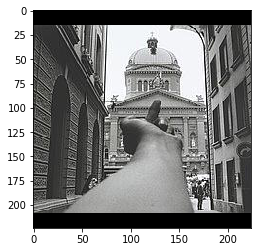

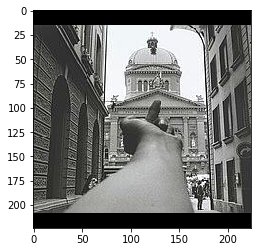

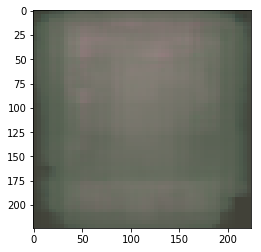

In [196]:
images, images_mod = noisy_dataset.get(500)

imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(images_mod))

reconstructed_imgs, *_ = dvae(images_mod.view(1, 3, 224, 224))
reconstructed_imgs = reconstructed_imgs.detach()

imshow(torchvision.utils.make_grid(reconstructed_imgs))

# .. 

In [138]:
# latent dim = 100
temp_net = nn.Sequential(
            nn.Conv2d(3, 25, 5), nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(25, 20, 5), nn.ReLU(True),
            nn.ReLU(True),
            nn.MaxPool2d(4, 4),
            nn.Conv2d(20, 20, 5),
            nn.ReLU(True),
            nn.MaxPool2d(4, 4),
            Flatten(),
            nn.Linear(500, 256), nn.ReLU(True),
            nn.Linear(256, 128), 
)

temp_net(torch.rand(7, 3, 224, 224)).shape

torch.Size([7, 20, 5, 5])

In [160]:
temp_decoder = nn.Sequential(
    nn.Linear(100, 128), nn.ReLU(True),
    nn.Linear(128, 256), nn.ReLU(True),
    nn.Linear(256, 500), nn.ReLU(True),
    Reshape([20, 5, 5]),
    nn.Upsample(scale_factor=2),
    nn.ConvTranspose2d(20, 20, 4), nn.ReLU(True),
    nn.Upsample(scale_factor=4),
    nn.ConvTranspose2d(20, 20, 5), nn.ReLU(True),
    nn.Upsample(scale_factor=4),
    nn.ConvTranspose2d(20, 1, 1), nn.Sigmoid()
#             
)
temp_decoder(torch.rand(7, 100)).shape

/Users/heytitle/projects/venv-python3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


torch.Size([7, 1, 224, 224])

In [214]:
len(testloader.dataset)

0

In [213]:
dvae.eval()
test_images = np.zeros((len(testloader.dataset), 100))
test_loss = []
with torch.no_grad():
    for i, (x, x_mod) in enumerate(testloader):

        x_hat, z, z_mu, z_logvar = dvae(x_mod)

        test_images[i*4:(i+1)*4] = z
        
        test_loss.append(loss_function(x_hat, x, z_mu, z_logvar).item())

    test_loss = np.mean(test_loss)
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Test set loss: nan


/Users/heytitle/projects/venv-python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heytitle/projects/venv-python3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [199]:
test_images_normed = test_images / np.sqrt(np.sum(np.power(test_images, 2), axis=1)).reshape((-1, 1))

In [200]:
sim_matrix = test_images_normed.dot(test_images_normed.T)

In [201]:
nearest_neighbors = np.argsort(-sim_matrix, axis=1)

In [216]:
def find_similar_images(data_idx, nn=5):
    vision.image.show_image(testloader.dataset.get(data_idx)[0])

    axies = plt.subplots(1, nn, figsize=(2*nn,2))[1]
    similar_images = nearest_neighbors[data_idx, 1:(nn+1)]
    
    print('Visually similar images` indices : %s' % ','.join(map(str, similar_images)))
    
    for i, tt in enumerate(zip(axies, similar_images)):
        ax, idx = tt
        vision.image.show_image(testloader.dataset.get(idx)[0], ax=ax)

Visually similar images` indices : 3884,3967,5161,4967,3291


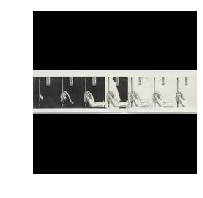

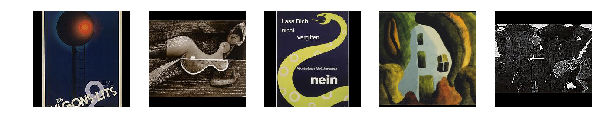

In [227]:
find_similar_images(10)

In [71]:
raw_images = testloader.dataset.data.view(-1, 784).numpy()
raw_test_images_normed = raw_images / np.sqrt(np.sum(np.power(raw_images, 2), axis=1)).reshape((-1, 1))
raw_sim_matrix = raw_test_images_normed.dot(raw_test_images_normed.T)
raw_nearest_neighbors = np.argsort(-raw_sim_matrix, axis=1)
raw_first_nn = raw_nearest_neighbors[:, 1]
raw_predicted_labels = true_labels[raw_first_nn]
print('Predict from pixel values: accuracy %.4f' % np.mean(true_labels == raw_predicted_labels))

Predict from pixel values: accuracy 0.5373


(10000, 10000)

In [83]:
first_nn = nearest_neighbors[:, 1]

In [89]:
predicted_labels = true_labels[first_nn]

In [90]:
predicted_labels

array([5, 4, 1, 1, ..., 1, 8, 3, 5])

In [ ]:
print('accuracy %.4f' % np.mean(true_labels == predicted_labels))

In [ ]:
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 20, 5),
            nn.BatchNorm2d(20),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 15, 5),
            nn.BatchNorm2d(15),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            Flatten(),
            nn.Linear(15 * 4 * 4, 120),
#             nn.Dropout(p=0.2),
            nn.ReLU(True),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 120),
            nn.ReLU(True),
            nn.Linear(120, 15*4*4),
            nn.ReLU(True),
            Reshape([15, 4, 4]),
            nn.ConvTranspose2d(15, 20, 2),
            nn.BatchNorm2d(20),
            nn.ConvTranspose2d(20, 10, 4),
            nn.BatchNorm2d(10),
            nn.ReLU(True),
            nn.ConvTranspose2d(10, 10, 4),
            nn.BatchNorm2d(10),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(10, 10, 5),
            nn.BatchNorm2d(10),
            nn.ConvTranspose2d(10, 1, 3),
            nn.Sigmoid()
        )

